<h1 style="width:750px">Airbnb and the Prevalence of Ghost Hotels in London</h1>

---

| CASA0013 | Introduction to Programming for Spatial Analysts | 
|----|----|
| Programme | MSc Smart Cities and Urban Analytics |
| Bartlett | Centre for Advanced Spatial Analytics |
| Word Count | 1,647 |
| Student ID | 19140941 |
| Date | 22-02-09 |

---

## Part 1 - Reproducible Analysis

Data for this analysis was downloaded from the Inside Airbnb website at http://insideairbnb.com/get-the-data.html.

| Data Downloaded | |  | |
|----|----|----|----|
|  09 August, 2019  |  London  |  listings.csv.gz  |  Detailed Listings data for London  |
|  N/A  |  London  |  neighbourhoods.csv  |  Neighbourhood list for geo filtering  |
|  N/A  |  London  |  neighbourhoods.geojson  |  GeoJSON file of city neighbourhoods  |

**Code:**

The csv file used in the reproducible analysis below and associated outputs can be downloaded from [GitHub](https://github.com/MattKavanaugh/I2P-Exec-Briefing). 

### Load Data

In [1]:
# load libraries
import csv
import os
from urllib.request import urlopen
from IPython import display

# Load numeric libraries
import geopandas as gpd
import math
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import sklearn
        
# load spatial libraries
import json
import pysal as ps
import mapclassify as mc
import palettable.matplotlib as palmpl
from legendgram import legendgram

In [2]:
# open data into a pandas dataframe
# ADD THIS WHEN FROM GITHUB - url = 'https://github.com/MattKavanaugh/I2P-Exec-Briefing'
# ADD THIS WHEN FROM GITHUB - abnb = pd.read_csv(url, compression='gzip', low_memory=False)
pdf = pd.read_csv('19-08_listings.csv.gz', compression='gzip', low_memory=False)

# confirm load
print(f"Data frame is {pdf.shape[0]:,} columns x {pdf.shape[1]} rows")

Data frame is 85,918 columns x 106 rows


### Review & Reduce Data

In [3]:
# check dataframe
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85918 entries, 0 to 85917
Columns: 106 entries, id to reviews_per_month
dtypes: float64(23), int64(21), object(62)
memory usage: 69.5+ MB


In [4]:
# check column names
print(list(pdf.columns.values))

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', '

In [5]:
# look at data
pdf.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,13913,https://www.airbnb.com/rooms/13913,20190809063821,2019-08-10,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,"Hello Everyone, I'm offering my lovely double ...",My bright double bedroom with a large window h...,business,Finsbury Park is a friendly melting pot commun...,...,f,f,moderate,f,f,3,1,2,0,0.15
1,15400,https://www.airbnb.com/rooms/15400,20190809063821,2019-09-13,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,Bright Chelsea Apartment This is a bright one...,Lots of windows and light. St Luke's Gardens ...,romantic,It is Chelsea.,...,t,f,strict_14_with_grace_period,t,t,1,1,0,0,0.73
2,17402,https://www.airbnb.com/rooms/17402,20190809063821,2019-08-10,Superb 3-Bed/2 Bath & Wifi: Trendy W1,"Open from June 2018 after a 3-year break, we a...",Ready again from June 2018 for bookings after ...,"Open from June 2018 after a 3-year break, we a...",none,"Location, location, location! You won't find b...",...,t,f,strict_14_with_grace_period,f,f,15,15,0,0,0.40
3,24328,https://www.airbnb.com/rooms/24328,20190809063821,2019-08-10,Battersea bedroom & office w parking shared ga...,"Artist house, bright high ceiling rooms, priva...",- End of terrace two bedroom house close to So...,"Artist house, bright high ceiling rooms, priva...",family,"- Battersea is a quiet family area, easy acces...",...,f,f,moderate,t,t,1,1,0,0,0.87
4,25023,https://www.airbnb.com/rooms/25023,20190809063821,2019-08-10,All-comforts 2-bed flat near Wimbledon tennis,"Large, all comforts, 2-bed flat; first floor; ...",10 mins walk to Southfields tube and Wimbledon...,"Large, all comforts, 2-bed flat; first floor; ...",none,This is a leafy residential area with excellen...,...,f,f,moderate,f,f,1,1,0,0,0.74


In [6]:
# drop columns we don't think we will need or that we think have any directly identifiable information
cols2drop = ['listing_url', 'scrape_id', 'last_scraped', 'summary', 'space', 'experiences_offered', 'notes', 
             'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 
             'xl_picture_url', 'host_url', 'host_name', 'host_since', 'host_about', 'host_response_time', 'host_response_rate', 
             'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 
             'host_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 
             'neighbourhood', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 
             'smart_location', 'country_code', 'country', 'is_location_exact', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 
             'amenities', 'square_feet', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 
             'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 
             'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 
             'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 
             'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm', 'first_review', 'last_review', 
             'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
             'review_scores_communication', 'review_scores_location', 'review_scores_value', 'requires_license', 
             'license', 'jurisdiction_names', 'instant_bookable', 'is_business_travel_ready', 'cancellation_policy', 
             'require_guest_profile_picture', 'require_guest_phone_verification', 'calculated_host_listings_count_shared_rooms', 
             'reviews_per_month']
for col in pdf.columns:
    if col in cols2drop:
        pdf.drop(col, inplace=True, axis=1)

In [7]:
# check reduced dataframe
print(f"Data frame is {pdf.shape[0]:,} columns x {pdf.shape[1]} rows")

# check reduced column names
print(list(pdf.columns.values))

Data frame is 85,918 columns x 22 rows
['id', 'name', 'description', 'neighborhood_overview', 'host_id', 'host_location', 'host_neighbourhood', 'host_total_listings_count', 'street', 'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'price', 'weekly_price', 'monthly_price', 'minimum_nights', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms']


In [8]:
# look at a few columns in more detail to see if we can drop more
pdf.head()[['name', 'description', 'neighborhood_overview', 'host_location', 
           'host_neighbourhood', 'host_total_listings_count', 'street', 
           'neighbourhood_cleansed', 'price', 'weekly_price', 'monthly_price', 
           'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 
           'calculated_host_listings_count_private_rooms']]

,name,description,neighborhood_overview,host_location,host_neighbourhood,host_total_listings_count,street,neighbourhood_cleansed,price,weekly_price,monthly_price,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms
0,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,"London, England, United Kingdom",LB of Islington,4.0,"Islington, Greater London, United Kingdom",Islington,$65.00,$333.00,"$1,176.00",3,1,2
1,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,It is Chelsea.,"Kensington, England, United Kingdom",Chelsea,1.0,"London, United Kingdom",Kensington and Chelsea,$100.00,$600.00,"$2,250.00",1,1,0
2,Superb 3-Bed/2 Bath & Wifi: Trendy W1,"Open from June 2018 after a 3-year break, we a...","Location, location, location! You won't find b...","London, England, United Kingdom",Fitzrovia,19.0,"London, Fitzrovia, United Kingdom",Westminster,$300.00,"$1,378.00",NaN,15,15,0
3,Battersea bedroom & office w parking shared ga...,"Artist house, bright high ceiling rooms, priva...","- Battersea is a quiet family area, easy acces...","London, England, United Kingdom",Battersea,2.0,"London, United Kingdom",Wandsworth,$175.00,"$1,050.00","$3,500.00",1,1,0
4,All-comforts 2-bed flat near Wimbledon tennis,"Large, all comforts, 2-bed flat; first floor; ...",This is a leafy residential area with excellen...,"Rome, Lazio, Italy",Wimbledon,1.0,"Wimbledon, London, United Kingdom",Wandsworth,$65.00,$630.00,"$2,515.00",1,1,0


In [9]:
# Data review
# 1. Descriptions - 3 fields
    # the name, description, and neighoburhood overview fields seem to come directly from the hosts
    # these will be valuable for later analysis

# 2. Locations - 4 fields
    # the host_location, host_neighbourhood, street, and neighbourhood cleansed fields are all over the place
    # likely partly to user error during entry (deliberate or otherwise), scraping methods, and/or Airbnb itself
    # for ease of use, we will keep the neighbourhood_cleansed and drop the other 3

# 3. Host Listing Counts - 4 fields
    # the host__listings_count fields also seem to vary and can easily be calculated on our own
    # we will drop all 4 of these
    
# 4. Prices - 3 fields
    # we will need to convert these to remove the $ sign

morecols2drop = ['host_location', 'host_neighbourhood', 'host_total_listings_count', 'street', 
                 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 
                 'calculated_host_listings_count_private_rooms']
for col in pdf.columns:
    if col in morecols2drop:
        pdf.drop(col, inplace=True, axis=1)

In [10]:
# check final dataframe
print(f"Data frame is {pdf.shape[0]:,} columns x {pdf.shape[1]} rows")

# check final column names
print(list(pdf.columns.values))

Data frame is 85,918 columns x 15 rows
['id', 'name', 'description', 'neighborhood_overview', 'host_id', 'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'price', 'weekly_price', 'monthly_price', 'minimum_nights']


In [11]:
# save raw data
# ADD THIS WHEN FROM GITHUB - fn   = url.split('/')[-1]
path = os.path.join('data','raw')
fn = '19-08_listings'
print(f"Writing to: {fn}")

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
pdf.to_csv(os.path.join(path,fn), index=False)
print("Done.")

Writing to: 19-08_listings
Done.


### Clean Data

In [12]:
# reload data
del(pdf)
pdf = pd.read_csv(os.path.join(path,fn), low_memory=False)
print(f"Data frame is {pdf.shape[0]:,} columns x {pdf.shape[1]} rows")

Data frame is 85,918 columns x 15 rows


In [13]:
# first we will count nulls by columns to identify if there are any problems
pdf.isnull().sum(axis=0).sort_values(ascending=False)

monthly_price             80656
weekly_price              78546
neighborhood_overview     31292
description                2159
name                         26
minimum_nights                0
price                         0
accommodates                  0
room_type                     0
property_type                 0
longitude                     0
latitude                      0
neighbourhood_cleansed        0
host_id                       0
id                            0
dtype: int64

In [14]:
# we will drop 'monthly_price','weekly_price', and 'neighborhood_overview'
pdf.drop(columns=['neighborhood_overview', 'weekly_price', 'monthly_price'], inplace=True)

In [15]:
# we will now count nulls by rows
pdf.isnull().sum(axis=1).sort_values(ascending=False)

24594    2
85917    1
76442    1
33437    1
50403    1
        ..
56222    0
56223    0
56224    0
56225    0
0        0
Length: 85918, dtype: int64

In [16]:
# no need to drop any

# now let's see how many rows have NaNs in key columns
pdf[pdf.id.isna()][['id', 'name', 'host_id']]

,id,name,host_id


In [17]:
# no issues

# now let's check datatypes
pdf.dtypes

id                          int64
name                       object
description                object
host_id                     int64
neighbourhood_cleansed     object
latitude                  float64
longitude                 float64
property_type              object
room_type                  object
accommodates                int64
price                      object
minimum_nights              int64
dtype: object

In [18]:
# Data to clean

# 1. The following fields will need to be converted to integer
    # 'id', 'host_id', 'accommodates', 'minimum_nights'

# 2. The following fields will need to be converted to float
    # 'latitude', 'longitude', 'price'
    
# 3. The following fields will need to be converted to string
    # 'name', 'description'

# 4. A geometry column will need to be created from the 'latitude' and 'longitude' fields

##### Convert selected columns to integer

In [19]:
# convert 'id', 'host_id', 'accommodates', 'minimum_nights'
pdf['id'] = pdf['id'].astype("int")
pdf['host_id'] = pdf['host_id'].astype("int")
pdf['accommodates'] = pdf['accommodates'].astype("int")
pdf['minimum_nights'] = pdf['minimum_nights'].astype("int")

# confirm changes
pdf.dtypes

id                          int64
name                       object
description                object
host_id                     int64
neighbourhood_cleansed     object
latitude                  float64
longitude                 float64
property_type              object
room_type                  object
accommodates                int64
price                      object
minimum_nights              int64
dtype: object

##### Convert selected columns to float

In [20]:
# convert price
pdf['price'] = pdf['price'].str.replace("[$, ]", "").astype("float")

# convert latitude and longitude
pdf['latitude'] = pdf['latitude'].astype("float")
pdf['longitude'] = pdf['longitude'].astype("float")

# confirm changes
pdf.dtypes

id                          int64
name                       object
description                object
host_id                     int64
neighbourhood_cleansed     object
latitude                  float64
longitude                 float64
property_type              object
room_type                  object
accommodates                int64
price                     float64
minimum_nights              int64
dtype: object

##### Reduce to only 'short term rentals'

In [21]:
# monthly sublets are a legitimate practice that can be found throughout cities worldwide, especially those with student populations
# to avoid including any of these we will classify a short term rental as any listing offering
# a minimum night stay less than 28 days (to account for the month of February)
# the rest we will drop

# let's see how many listings we have now
pdf['id'].count()

85918

In [22]:
# we will create indexes of listings where minimum_nights is greater than 28
indexNames = pdf[pdf['minimum_nights'] > 28].index

# Drop these listings
pdf.drop(indexNames , inplace=True)

# let's see how many listings we have left
pdf['id'].count()

84412

In [23]:
tl = 85918
stl = 84412

print(f"{round(((stl/tl)*100), 2)}% of all listings offer short term rentals")

98.25% of all listings offer short term rentals


In [24]:
# we no longer need the minimum nights column so it can be dropped
pdf.drop('minimum_nights', axis=1, inplace=True)

# confirm changes
pdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84412 entries, 0 to 85917
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      84412 non-null  int64  
 1   name                    84387 non-null  object 
 2   description             82295 non-null  object 
 3   host_id                 84412 non-null  int64  
 4   neighbourhood_cleansed  84412 non-null  object 
 5   latitude                84412 non-null  float64
 6   longitude               84412 non-null  float64
 7   property_type           84412 non-null  object 
 8   room_type               84412 non-null  object 
 9   accommodates            84412 non-null  int64  
 10  price                   84412 non-null  float64
dtypes: float64(3), int64(3), object(5)
memory usage: 7.7+ MB


##### Clean up categories

In [25]:
# check property type counts by percentage
pdf.property_type.value_counts(normalize=True)

Apartment                 0.664669
House                     0.211155
Townhouse                 0.035635
Condominium               0.023160
Serviced apartment        0.021715
Bed and breakfast         0.010544
Loft                      0.008411
Guest suite               0.004170
Guesthouse                0.003471
Boutique hotel            0.002867
Hostel                    0.002713
Other                     0.002417
Hotel                     0.001730
Bungalow                  0.001587
Cottage                   0.001031
Villa                     0.000746
Boat                      0.000723
Aparthotel                0.000723
Tiny house                0.000604
Houseboat                 0.000344
Cabin                     0.000296
Camper/RV                 0.000190
Casa particular (Cuba)    0.000190
Chalet                    0.000166
Earth house               0.000154
Hut                       0.000130
Barn                      0.000130
Farm stay                 0.000047
Yurt                

In [26]:
# The top five seem to represent the vast majority of all listings
pdf.property_type.value_counts(normalize=True)[:5].sum().round(2)

0.96

In [27]:
# we will keep the top 5 and merge all else into an "Other" label

top5 = list(pdf.property_type.value_counts(normalize=True)[:5].index)

pdf.property_type = [x if x in top5 else 'Other' for x in pdf.property_type]

pdf.property_type.value_counts(normalize=True)

Apartment             0.664669
House                 0.211155
Other                 0.043667
Townhouse             0.035635
Condominium           0.023160
Serviced apartment    0.021715
Name: property_type, dtype: float64

##### Identify and remove outliers

In [28]:
# use the Interquartile Rule (IQR Score)
    # Calculate the IQR
    # Multiply the IQR by 1.5 (a constant used to discern outliers)
    # Add 1.5 x (IQR) to the third quartile (75%). Any number greater than this is a suspected outlier.
    # Subtract 1.5 x (IQR) from the first quartile (25%). Any number less than this is a suspected outlier.
# credit to: https://github.com/brunacmendes/Airbnb_Data_Analysis_Toronto/blob/main/Airbnb_Listings_Data_Analysis_Toronto.ipynb
    
# first select relevant data
pdf[['accommodates', 'price']].describe().round(1)

,accommodates,price
count,84412.0,84412.0
mean,3.2,121.6
std,2.0,222.3
min,0.0,0.0
25%,2.0,45.0
50%,2.0,81.0
75%,4.0,140.0
max,20.0,13700.0


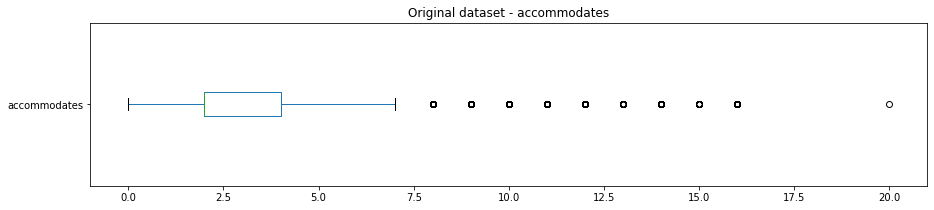

IQR accommodates:  2.0
Upper limit:  7.0
Lower limit:  -1.0
3591 Entries above upper limit
4.25% of dataset


In [29]:
# Displaying the box plot for accommodates
fig, ax = plt.subplots(figsize=(15,3))
pdf['accommodates'].plot(kind='box', vert=False)
ax.set_title('Original dataset - accommodates')
plt.show()

# IQR rule for variable accommodates
q1_mn = pdf.accommodates.quantile(q=0.25)
q3_mn = pdf.accommodates.quantile(q=0.75)
IQR_mn = q3_mn - q1_mn

print('IQR accommodates: ', IQR_mn)

sup_mn = q3_mn + 1.5 * IQR_mn
inf_mn = q1_mn - 1.5 * IQR_mn

print('Upper limit: ', sup_mn)
print('Lower limit: ', inf_mn)

print("{} Entries above upper limit".format(len(pdf[pdf.accommodates > sup_mn])))
print("{:.2f}% of dataset".format((len(pdf[pdf.accommodates > sup_mn]) / pdf.shape[0])*100))

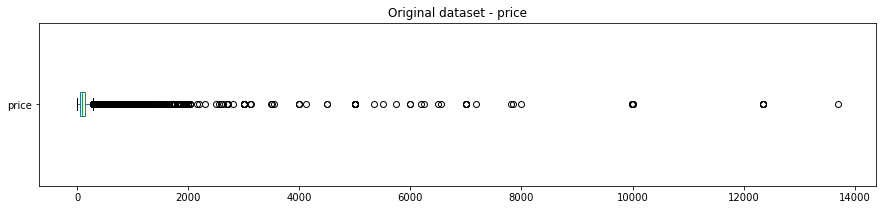

IQR price:  95.0
Upper limit:  282.5
Lower limit:  -97.5
5582 Entries above upper limit
6.61% of dataset


In [30]:
# Display the box plot for price
fig, ax = plt.subplots(figsize=(15,3))
pdf['price'].plot(kind='box', vert=False)
ax.set_title('Original dataset - price')
plt.show()

# IQR rule for variable price
q1_price = pdf.price.quantile(q=0.25)
q3_price = pdf.price.quantile(q=0.75)
IQR_price = q3_price - q1_price

print('IQR price: ', IQR_price)

sup_price = q3_price + 1.5 * IQR_price
inf_price = q1_price - 1.5 * IQR_price

print('Upper limit: ', sup_price)
print('Lower limit: ', inf_price)

print("{} Entries above upper limit".format(len(pdf[pdf.price > sup_price])))
print("{:.2f}% of dataset".format((len(pdf[pdf.price > sup_price]) / pdf.shape[0])*100))

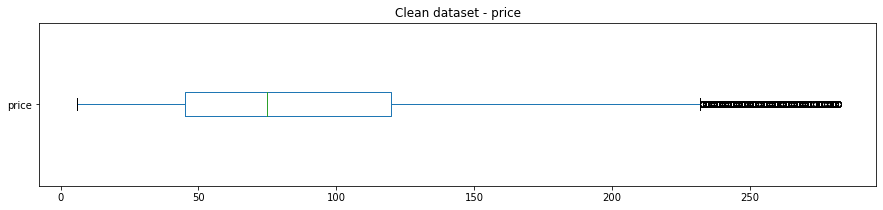

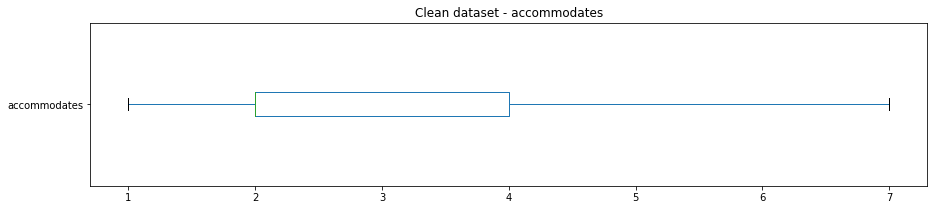

In [31]:
# Select the rows that fulfil the established requirements
pdf = pdf[(pdf['price'] <= 282.5) & (pdf['price'] > 0) & (pdf['accommodates'] <= 7.0)].copy()

#plotting the boxplots again
fig, ax = plt.subplots(figsize=(15,3))
pdf['price'].plot(kind='box', vert=False)
ax.set_title('Clean dataset - price')
plt.show()

fig, ax = plt.subplots(figsize=(15,3))
pdf['accommodates'].plot(kind='box', vert=False)
ax.set_title('Clean dataset - accommodates')
plt.show()

In [32]:
# confirm changes 
pdf[['accommodates', 'price']].describe().round(1)

,accommodates,price
count,76692.0,76692.0
mean,2.8,88.7
std,1.5,56.3
min,1.0,6.0
25%,2.0,45.0
50%,2.0,75.0
75%,4.0,120.0
max,7.0,282.0


##### Add geometry

In [33]:
# create a geometry column and geodataframe from the 'latitude' and 'longitude'
gdf = gpd.GeoDataFrame(pdf, 
      geometry=gpd.points_from_xy(pdf['longitude'], pdf['latitude'], crs='epsg:4326'))

epsg:4326
[-0.49582 51.29479  0.29657 51.68169]


<AxesSubplot:>

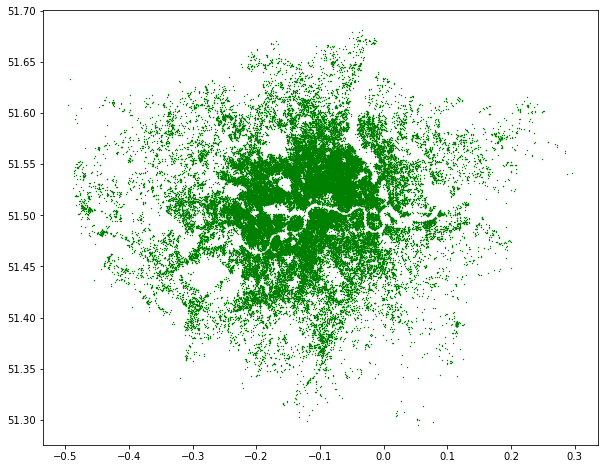

In [34]:
# confirm created
print(gdf.geometry.crs)
print(gdf.total_bounds)
gdf.plot(figsize=(12,8), marker='*', color='green', markersize=0.25)

epsg:27700
[504260.19373861 157077.66437635 559358.41568316 199932.45808543]


<AxesSubplot:>

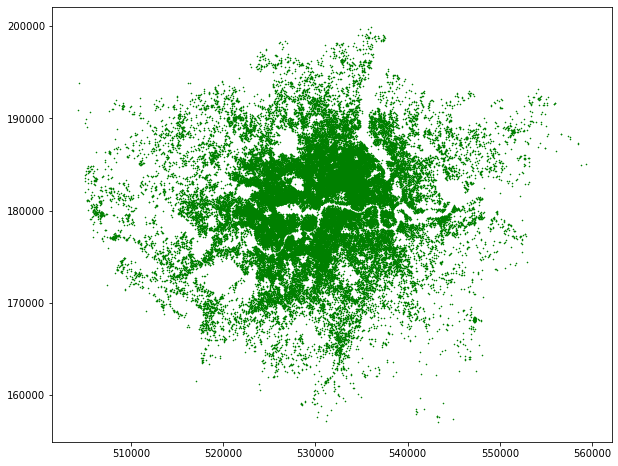

In [35]:
# change projection to BNG
gdf = gdf.to_crs("epsg:27700")
print(gdf.geometry.crs)
print(gdf.total_bounds)
gdf.plot(figsize=(12,8), marker='*', color='green', markersize=0.5)

In [36]:
# read in json file
lon_nbs = gpd.read_file('http://data.insideairbnb.com/united-kingdom/england/london/2021-12-07/visualisations/neighbourhoods.geojson')
lon_nbs.head()

,neighbourhood,neighbourhood_group,geometry
0,Kingston upon Thames,None,"MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51..."
1,Croydon,None,"MULTIPOLYGON (((-0.06402 51.31864, -0.06407 51..."
2,Bromley,None,"MULTIPOLYGON (((0.01213 51.29960, 0.01196 51.2..."
3,Hounslow,None,"MULTIPOLYGON (((-0.24456 51.48870, -0.24468 51..."
4,Ealing,None,"MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51..."


In [37]:
# we will need to merge neighbourhood with neighbourhood_cleansed from our dataframe
# we will rename neighbourhood and drop neighbourhood group to avoid confusion
lon_nbs.rename(columns={'neighbourhood': 'neighbourhood_cleansed'}, inplace=True)
lon_nbs.drop('neighbourhood_group', axis=1, inplace=True)

# check to confirm
lon_nbs.head()

,neighbourhood_cleansed,geometry
0,Kingston upon Thames,"MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51..."
1,Croydon,"MULTIPOLYGON (((-0.06402 51.31864, -0.06407 51..."
2,Bromley,"MULTIPOLYGON (((0.01213 51.29960, 0.01196 51.2..."
3,Hounslow,"MULTIPOLYGON (((-0.24456 51.48870, -0.24468 51..."
4,Ealing,"MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51..."


epsg:4326
[-0.510375 51.28676   0.334016 51.691874]


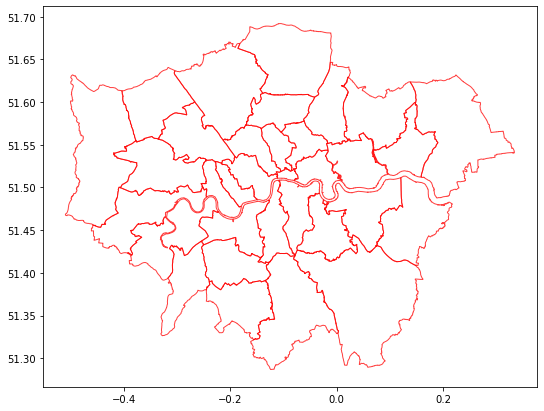

In [38]:
# plot 
print(lon_nbs.geometry.crs)
print(lon_nbs.total_bounds)
ax = lon_nbs.plot(figsize=(10,7), edgecolor='red', facecolor='none', linewidth=1, alpha=0.75)

epsg:27700
[504260.19373861 157077.66437635 559358.41568316 199932.45808543]


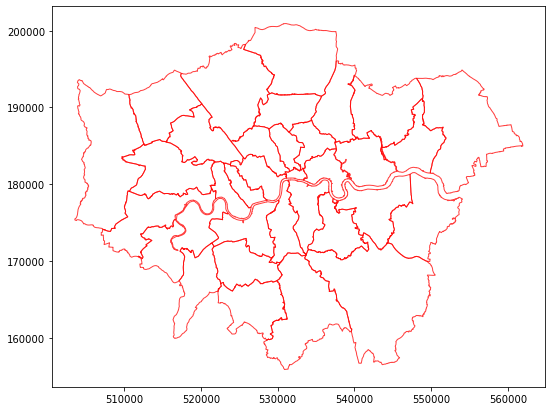

In [39]:
# change projection to BNG
lon_nbs = lon_nbs.to_crs("epsg:27700")
print(gdf.geometry.crs)
print(gdf.total_bounds)
ax = lon_nbs.plot(figsize=(10,7), edgecolor='red', facecolor='none', linewidth=1, alpha=0.75)

### Save Data

In [40]:
# final check of dataframe
pdf.head()

,id,name,description,host_id,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,price,geometry
0,13913,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,54730,Islington,51.56802,-0.11121,Apartment,Private room,2,65.0,POINT (-0.11121 51.56802)
4,25023,All-comforts 2-bed flat near Wimbledon tennis,"Large, all comforts, 2-bed flat; first floor; ...",102813,Wandsworth,51.44687,-0.21874,Apartment,Entire home/apt,4,65.0,POINT (-0.21874 51.44687)
5,25123,Clean big Room in London (Room 1),Big room with double bed/ clean sheets/ clean ...,103583,Barnet,51.57224,-0.20906,House,Private room,2,29.0,POINT (-0.20906 51.57224)
6,26223,FREE WIFI!! Angel Bright Ap Private Terrace by...,Contemporary design meets classic London in th...,110865,Islington,51.54168,-0.10207,Apartment,Entire home/apt,4,147.0,POINT (-0.10207 51.54168)
7,26482,FREE WIFI! Stunning Penthouse Apt Business D Ctr,Contemporary design meets classic London in th...,110865,Islington,51.53883,-0.10153,Apartment,Entire home/apt,5,147.0,POINT (-0.10153 51.53883)


In [41]:
# save dataframe

path = os.path.join('data','clean')
fn = '19-08_listings'

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
pdf.to_csv(os.path.join(path,fn), index=False)
print("Done.")

Done.


### Save Geodata

In [42]:
# check geodataframe
gdf.head()

,id,name,description,host_id,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,price,geometry
0,13913,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,54730,Islington,51.56802,-0.11121,Apartment,Private room,2,65.0,POINT (531005.968 187150.843)
4,25023,All-comforts 2-bed flat near Wimbledon tennis,"Large, all comforts, 2-bed flat; first floor; ...",102813,Wandsworth,51.44687,-0.21874,Apartment,Entire home/apt,4,65.0,POINT (523881.657 173491.396)
5,25123,Clean big Room in London (Room 1),Big room with double bed/ clean sheets/ clean ...,103583,Barnet,51.57224,-0.20906,House,Private room,2,29.0,POINT (524213.146 187449.516)
6,26223,FREE WIFI!! Angel Bright Ap Private Terrace by...,Contemporary design meets classic London in th...,110865,Islington,51.54168,-0.10207,Apartment,Entire home/apt,4,147.0,POINT (531715.404 184238.134)
7,26482,FREE WIFI! Stunning Penthouse Apt Business D Ctr,Contemporary design meets classic London in th...,110865,Islington,51.53883,-0.10153,Apartment,Entire home/apt,5,147.0,POINT (531761.074 183922.175)


In [43]:
# save geodataframe
gdf.to_file('19-08-listings.gpkg', driver='GPKG')

# Set save location
path = os.path.join('data','geo')
fn = '19-08-listings.gpkg'

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
print(f"Using '{fn}' as basis for saving data...")

gdf.to_file(os.path.join('data','geo',fn.replace('.csv.gz','.gpkg')), driver='GPKG')
print("Done.")

Using '19-08-listings.gpkg' as basis for saving data...
Done.


#### Analysis

In [44]:
# let's see the statistics for all short term rentals

print(f"in our sample of all short term listings, there are {gdf.id.nunique()} total listings however there are only {gdf.host_id.nunique()} total hosts ...")
print(f"... meaning there are {(gdf.id.nunique())-(gdf.host_id.nunique())} or {round((25571/76692)*100,2)}% more listings than hosts...")
print(f"... with enough nightly accommodations for {pdf.accommodates.sum()} people with an average of {round(gdf.accommodates.mean(),1)} people per listing ...")
print(f"... an average price for a listing of ${round(gdf.price.mean(),2)} per night...")
print(f"... and at a profit of ${round(gdf.price.sum())} per night if all listings were booked at the same time")

in our sample of all short term listings, there are 76692 total listings however there are only 51121 total hosts ...
... meaning there are 25571 or 33.34% more listings than hosts...
... with enough nightly accommodations for 217492 people with an average of 2.8 people per listing ...
... an average price for a listing of $88.69 per night...
... and at a profit of $6802085 per night if all listings were booked at the same time


In [45]:
# now lets check statistics for all short term listings by hosts with more than one listing
multi_host = gdf[gdf.host_id.duplicated(keep=False)]

In [46]:
# let's see the stats for all short term multi-host listings
print(f"in our sample of short term multi-host listings, there are {multi_host.id.nunique()} total listings however there are only {multi_host.host_id.nunique()} total hosts ...")
print(f"... meaning there are {(multi_host.id.nunique())-(multi_host.host_id.nunique())} or {round((9186/34757)*100,2)}% more listings than hosts ...")
print(f"... with enough nightly accommodations for {multi_host.accommodates.sum()} people with an average of {round(multi_host.accommodates.mean(),1)} people per listing ...")
print(f"... an average price for a listing of ${round(multi_host.price.mean(),2)} per night ...")
print(f"... and at a profit of ${round(multi_host.price.sum())} per night if all listings were booked at the same time.")

in our sample of short term multi-host listings, there are 34757 total listings however there are only 9186 total hosts ...
... meaning there are 25571 or 26.43% more listings than hosts ...
... with enough nightly accommodations for 104487 people with an average of 3.0 people per listing ...
... an average price for a listing of $95.89 per night ...
... and at a profit of $3332875 per night if all listings were booked at the same time.


In [47]:
# and lets compare the stats
print(f"in comparison, multi-host listings make up {round(multi_host.id.nunique()/gdf.id.nunique()*100,2)}% of total listings...")
print(f"... meaning that only {multi_host.host_id.nunique()} or {round(multi_host.host_id.nunique()/gdf.host_id.nunique()*100,2)}% of all hosts control ...")
print(f"... {round(multi_host.id.nunique()/gdf.id.nunique()*100,2)}% of all listings ...")
print(f"... {round(multi_host.accommodates.sum()/gdf.accommodates.sum()*100,2)}% of all nightly accommodations at an average of {round(((multi_host.accommodates.mean())-(gdf.accommodates.mean())),1)} more people per listing ...")
print(f"... and at an average of ${round(((multi_host.price.mean())-(gdf.price.mean())),2)} more per night ...")
print(f"... for approximately {round(multi_host.price.sum()/gdf.price.sum()*100,2)}% of nighlty profits for all listings, if they were all booked at the same time.")

in comparison, multi-host listings make up 45.32% of total listings...
... meaning that only 9186 or 17.97% of all hosts control ...
... 45.32% of all listings ...
... 48.04% of all nightly accommodations at an average of 0.2 more people per listing ...
... and at an average of $7.2 more per night ...
... for approximately 49.0% of nighlty profits for all listings, if they were all booked at the same time.


/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "index" which is no longer supported as of 3.3 and will become an error two minor releases later


Done.


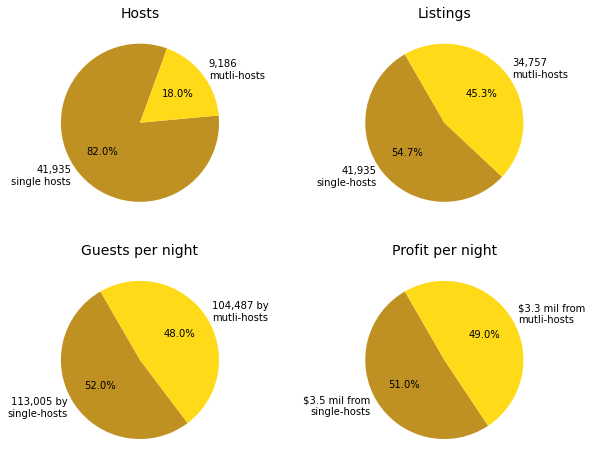

In [48]:
# visualize statistics
plt.figure(figsize = [10, 8])

# Define data coordinates and labels
hosts = ['41,935\nsingle hosts', '9,186\nmutli-hosts']
hosts_num = [41935, 9186]
listings = ['41,935\nsingle-hosts', '34,757\nmutli-hosts']
listing_num = [41935, 34757]
accoms = ['113,005 by\nsingle-hosts', '104,487 by\nmutli-hosts']
accoms_num = [113005, 104487]
profit = ['$3.5 mil from\nsingle-hosts', '$3.3 mil from\nmutli-hosts']
profit_num = [3469210, 3332875]

# number of hosts 
plt.subplot(2, 2, 1)
plt.pie(hosts_num,labels=hosts, colors = ['darkgoldenrod','gold'], autopct='%1.1f%%', startangle=70, wedgeprops={'alpha':0.9})
plt.title('Hosts', fontsize=14, color='black')

# number of listings
plt.subplot(2, 2, 2)
plt.pie(listing_num,labels=listings, colors = ['darkgoldenrod','gold'], autopct='%1.1f%%', startangle=120, wedgeprops={'alpha':0.9})
plt.title('Listings', fontsize=14, color='black')

# number of people being accomodated
plt.subplot(2, 2, 3) 
plt.pie(accoms_num,labels=accoms, colors = ['darkgoldenrod','gold'], autopct='%1.1f%%', startangle=120, wedgeprops={'alpha':0.9})
plt.title('Guests per night', fontsize=14, color='black')

# amount of profit
plt.subplot(2, 2, 4) 
plt.pie(profit_num,labels=profit, colors = ['darkgoldenrod','gold'], autopct='%1.1f%%', startangle=120, wedgeprops={'alpha':0.9})
plt.title('Profit per night', fontsize=14, color='black')

# save fig
path = os.path.join('','image')
fn = 'fig1'

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
plt.savefig(os.path.join(path,fn), index=False)
print("Done.")

# show plot
plt.show()

In [49]:
# number of multi host listings by type of property
multi_host.property_type.value_counts()

Apartment             23327
House                  6401
Other                  1736
Townhouse              1248
Serviced apartment     1187
Condominium             858
Name: property_type, dtype: int64

In [50]:
# apartments make up more multi host listings than all other categories combined
# let's look at number of multi host listings by type of room
multi_host.room_type.value_counts()

Entire home/apt    18575
Private room       15844
Shared room          333
Hotel room             5
Name: room_type, dtype: int64

In [51]:
# and the percentages ..
# percentage of multi host listings by room type
multi_host_room_per = round((multi_host.room_type.value_counts() / multi_host.shape[0] *100), 1)
print(multi_host_room_per)

Entire home/apt    53.4
Private room       45.6
Shared room         1.0
Hotel room          0.0
Name: room_type, dtype: float64


/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "index" which is no longer supported as of 3.3 and will become an error two minor releases later


Done.


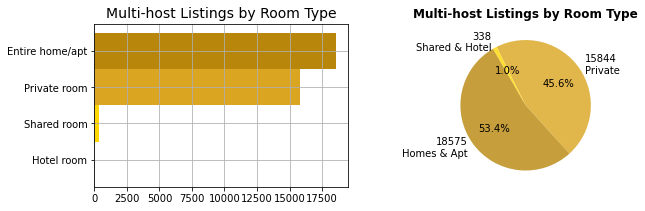

In [52]:
# theres a more even split here between entire homes/aprts and private rooms
# let's visualize this ...
plt.figure(figsize = [12, 8])

# first subplot (1 row, 2 columns, position 1)
plt.subplot(1, 2, 1)
multi_host_freq = multi_host['room_type'].value_counts().sort_values(ascending=True)
multi_host_freq.plot.barh(figsize =(10,3), width=1, color=['khaki','gold','goldenrod','darkgoldenrod'])
plt.title("Multi-host Listings by Room Type", fontsize=14)
plt.grid(True)

# second subplot (1 row, 2 columns, position 2)
plt.subplot(1, 2, 2)
labels = ['18575\nHomes & Apt', '15844\nPrivate', '338\nShared & Hotel']
sizes = [53.4, 45.6, 1.0]
plt.pie(sizes,labels=labels, colors = ['darkgoldenrod','goldenrod','gold'], autopct='%1.1f%%', startangle=120, wedgeprops={'alpha':0.8})
plt.title('Multi-host Listings by Room Type', fontsize=12, color='black', fontweight='bold')

# save fig
path = os.path.join('','image')
fn = 'fig2'

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
plt.savefig(os.path.join(path,fn), index=False)
print("Done.")

plt.show()

In [53]:
# check counts
multi_host.room_type.value_counts()

Entire home/apt    18575
Private room       15844
Shared room          333
Hotel room             5
Name: room_type, dtype: int64

In [54]:
# check total
multi_host.id.count()

34757

In [55]:
# average price for multi listings by neighbourhood

prices = multi_host.groupby(
    ["neighbourhood_cleansed"], as_index=False
).agg(
    avg_price = ("price", "mean"),
    qty = ("price", "count")
).sort_values(
    by="avg_price", ascending=False
).reset_index(drop=True)

print(prices)

    neighbourhood_cleansed   avg_price   qty
0           City of London  155.696864   287
1   Kensington and Chelsea  141.319793  2708
2              Westminster  132.786263  4819
3                   Camden  115.116943  2839
4                Islington  102.021858  2013
5   Hammersmith and Fulham  100.543933  1912
6     Richmond upon Thames   95.274194   372
7               Wandsworth   94.233094  1390
8                Southwark   89.841252  1789
9                  Hackney   85.021978  1820
10                 Lambeth   83.572085  1741
11           Tower Hamlets   82.791719  3985
12                Hounslow   82.060386   414
13               Greenwich   76.849916   593
14                  Merton   76.639676   494
15                   Brent   69.279963  1093
16                  Newham   68.667458   842
17                Havering   67.317757   107
18                  Barnet   66.531646   632
19                  Ealing   64.834492   719
20                Haringey   61.480712   674
21        

In [56]:
prices_map = lon_nbs.merge(prices, on='neighbourhood_cleansed')
prices_map.head()

,neighbourhood_cleansed,geometry,avg_price,qty
0,Kingston upon Thames,"MULTIPOLYGON (((516401.602 160201.799, 516407....",58.148571,175
1,Croydon,"MULTIPOLYGON (((535009.214 159504.738, 535005....",57.606426,498
2,Bromley,"MULTIPOLYGON (((540373.602 157530.394, 540361....",56.886179,246
3,Hounslow,"MULTIPOLYGON (((521975.826 178099.981, 521967....",82.060386,414
4,Ealing,"MULTIPOLYGON (((510253.476 182881.615, 510249....",64.834492,719


/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "index" which is no longer supported as of 3.3 and will become an error two minor releases later
  del sys.path[0]


Done.


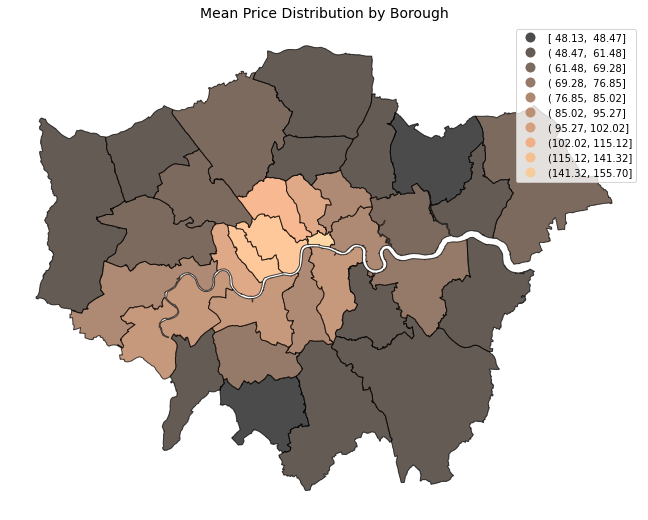

In [57]:
ax = prices_map.plot(figsize=(12,9), edgecolor='black', linewidth=1, alpha=0.7, column='avg_price', cmap='copper', scheme='Fisher_Jenks', legend=True, k=10)
#ax = multi_host.plot(markersize=0.1, color = 'black', scheme='Fisher_Jenks', ax=ax)
ax.set_title("Mean Price Distribution by Borough", fontsize=14)
plt.axis('off')

path = os.path.join('','image')
fn = 'fig3'

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
plt.savefig(os.path.join(path,fn), index=False)
print("Done.")

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "index" which is no longer supported as of 3.3 and will become an error two minor releases later
  


Done.


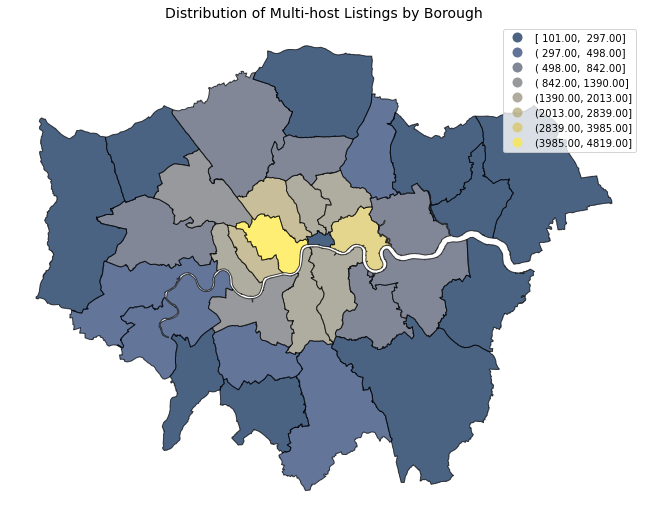

In [58]:
# distribution of multi-listers by neighbourhood
ax = prices_map.plot(figsize=(12,9), edgecolor='black', linewidth=1, alpha=0.7, column='qty', cmap='cividis', scheme='Fisher_Jenks', legend=True, k=8)
#ax = multi_host.plot(markersize=0.1, color = 'black', scheme='Fisher_Jenks', ax=ax)
ax.set_title("Distribution of Multi-host Listings by Borough", fontsize=14)
plt.axis('off')

path = os.path.join('','image')
fn = 'fig4'

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
plt.savefig(os.path.join(path,fn), index=False)
print("Done.")

In [59]:
# geographic distribution of multi lisitings
multi_host['neighbourhood_cleansed'].value_counts().sort_values(ascending=False)

Westminster               4819
Tower Hamlets             3985
Camden                    2839
Kensington and Chelsea    2708
Islington                 2013
Hammersmith and Fulham    1912
Hackney                   1820
Southwark                 1789
Lambeth                   1741
Wandsworth                1390
Brent                     1093
Newham                     842
Lewisham                   750
Ealing                     719
Haringey                   674
Barnet                     632
Greenwich                  593
Croydon                    498
Merton                     494
Waltham Forest             465
Hounslow                   414
Richmond upon Thames       372
Hillingdon                 297
Redbridge                  296
City of London             287
Enfield                    258
Bromley                    246
Harrow                     196
Kingston upon Thames       175
Barking and Dagenham       130
Havering                   107
Bexley                     102
Sutton  

In [60]:
# only keep neighbourhoods with over 600 listings (top 16)
multi_host['neighbourhood_cleansed'].value_counts().loc[lambda x : x>600] 

Westminster               4819
Tower Hamlets             3985
Camden                    2839
Kensington and Chelsea    2708
Islington                 2013
Hammersmith and Fulham    1912
Hackney                   1820
Southwark                 1789
Lambeth                   1741
Wandsworth                1390
Brent                     1093
Newham                     842
Lewisham                   750
Ealing                     719
Haringey                   674
Barnet                     632
Name: neighbourhood_cleansed, dtype: int64

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "index" which is no longer supported as of 3.3 and will become an error two minor releases later
  from ipykernel import kernelapp as app


Done.


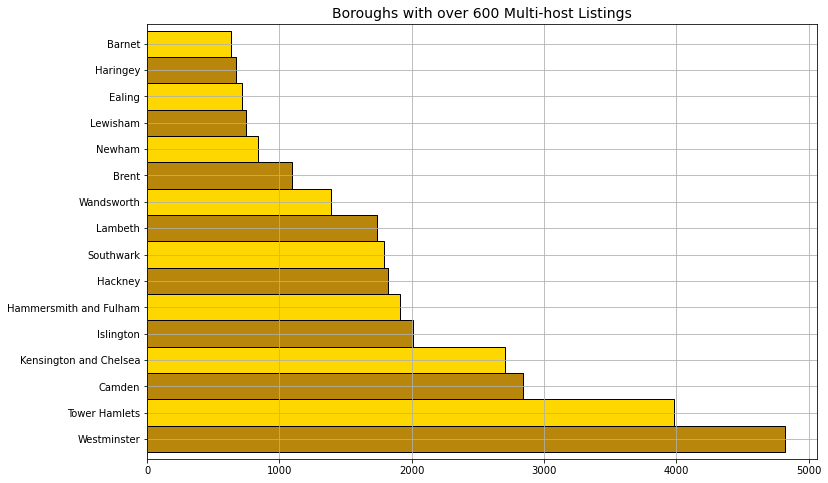

In [61]:
# distribution of multi-listers by neighbourhood
nbd_distrib = multi_host['neighbourhood_cleansed'].value_counts().loc[lambda x : x>600]
nbd_distrib.plot.barh(figsize =(12,8), width=1, color=['darkgoldenrod','gold'], edgecolor = "black")
plt.title("Boroughs with over 600 Multi-host Listings", fontsize=14)
plt.grid(True)

# save fig
path = os.path.join('','image')
fn = 'fig5'

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
plt.savefig(os.path.join(path,fn), index=False)
print("Done.")

plt.show()

In [62]:
# create a subset for our search for ghost hotels
# we will drop shared rooms and hotel rooms right away and leave just apartments and private rooms
ghost_hunt = gdf[gdf.host_id.duplicated(keep=False)]
ghost_hunt = ghost_hunt[ghost_hunt.room_type != 'Shared room']
ghost_hunt = ghost_hunt[ghost_hunt.room_type != 'Hotel room']

In [63]:
ghost_hunt.id.count()

34419

In [64]:
# hosts with more than 25 listings
freq1 = ghost_hunt.groupby(['host_id']).size().reset_index(name='num_host_listings')
freq1 = freq1.sort_values(by=['num_host_listings'], ascending=False)
freq1 = freq1[freq1['num_host_listings'] >= 25]
freq1

,host_id,num_host_listings
3976,33889201,646
3665,28820321,205
4758,48165024,164
350,1432477,138
2426,13557337,113
...,...,...
4080,35424755,25
4349,40412482,25
7374,159068368,25
6278,106387632,25


In [65]:
freq1.sum()

host_id              11410612207
num_host_listings           5952
dtype: int64

In [66]:
freq1.count()

host_id              115
num_host_listings    115
dtype: int64

In [67]:
# hosts with more than 50 listings
freq2 = ghost_hunt.groupby(['host_id']).size().reset_index(name='num_host_listings')
freq2 = freq2.sort_values(by=['num_host_listings'], ascending=False)
freq2 = freq2[freq2['num_host_listings'] >= 50]
freq2

,host_id,num_host_listings
3976,33889201,646
3665,28820321,205
4758,48165024,164
350,1432477,138
2426,13557337,113
4874,50291093,113
8369,224866971,106
6892,135969957,94
6899,136223256,90
5767,83740964,84


In [68]:
# hosts with more than 75 listings
#Display hosts with more than 75 listings
freq3 = ghost_hunt.groupby(['host_id']).size().reset_index(name='num_host_listings')
freq3 = freq3.sort_values(by=['num_host_listings'], ascending=False)
freq3 = freq3[freq3['num_host_listings'] >= 75]
freq3

,host_id,num_host_listings
3976,33889201,646
3665,28820321,205
4758,48165024,164
350,1432477,138
2426,13557337,113
4874,50291093,113
8369,224866971,106
6892,135969957,94
6899,136223256,90
5767,83740964,84


In [69]:
# hosts with more than 100 listings
#Display hosts with more than 100 listings
freq4 = ghost_hunt.groupby(['host_id']).size().reset_index(name='num_host_listings')
freq4 = freq4.sort_values(by=['num_host_listings'], ascending=False)
freq4 = freq4[freq4['num_host_listings'] >= 100]
freq4

,host_id,num_host_listings
3976,33889201,646
3665,28820321,205
4758,48165024,164
350,1432477,138
2426,13557337,113
4874,50291093,113
8369,224866971,106


In [70]:
# let's look at the top host with 646 listings
sus1 = ghost_hunt[ghost_hunt['host_id']==33889201]
sus1 = sus1[['id', 'name', 'host_id', 'description', 'neighbourhood_cleansed', 'property_type', 'room_type', 'geometry']]
sus1.index.name = "id"
sus1.sample(8, random_state=42)

,id,name,host_id,description,neighbourhood_cleansed,property_type,room_type,geometry
id,,,,,,,,
80651,36501046,"Ideal 4BR with garden, mins from riverside (Ve...",33889201,"With space for up to 7 guests, this home in So...",Wandsworth,House,Entire home/apt,POINT (524609.102 175132.569)
43812,22952000,Warm and homely 3 bed home in Hammersmith,33889201,This charming house is set over 3 floors and s...,Hammersmith and Fulham,Apartment,Entire home/apt,POINT (522189.819 178595.590)
42199,22275762,"Lovely home, sleeps 6, reach Oxford Circus in ...",33889201,"Set over 2 floors, this lovely home sleeps 6 p...",Islington,House,Entire home/apt,POINT (531998.256 186301.915)
39793,21577345,2BR in Bloomsbury; walk to Oxford Street! by V...,33889201,"Boasting a central location, this 2 bedroom fl...",Camden,Apartment,Entire home/apt,POINT (530150.910 181493.759)
16097,10920523,"Up to 20% off! 2-bed conversion, Tower Bridge",33889201,This newly renovated two bedroom apartment is ...,Tower Hamlets,Apartment,Entire home/apt,POINT (534318.362 181110.356)
47608,24465192,Spacious 3 bed home in Putney with garden,33889201,"Spacious 3 bedroom house in Putney, which slee...",Wandsworth,House,Entire home/apt,POINT (522511.948 174416.294)
69663,33446411,"2 BR in Hampstead, 15 mins to Soho, Veeve",33889201,A delightful 2 bedroom home in Hampstead Villa...,Camden,House,Entire home/apt,POINT (526430.700 185888.611)
77181,35670201,"2BR in Notting Hill, mins to Holland Park (Veeve)",33889201,"Situated on a charming Notting Hill Mews, this...",Kensington and Chelsea,House,Entire home/apt,POINT (524839.448 180500.364)


In [71]:
# the listings geographically scattered, but the listing name gives it away - "Veeve"
sus1['name']

id
9103      Wonderful 1 BR in Fulham with river views, Veeve
9105        Modern Thameside 2BR, Chelsea Bridge, by Veeve
9106     Sleek 1 BR with panoramic views, Pimlico, by V...
9114            3 BR with private garden, Putney, by Veeve
11941            Up to 20% off! Open-plan 2 bed, Islington
                               ...                        
83357    Ideal 1BR with lovely garden in Kensington (Ve...
83527    Sleek 3BR close to King’s Cross St Pancras (Ve...
85145    Stunning and bright garden flat in Fulham (Veeve)
85223        Contemporary 3BR in desirable Clapham (Veeve)
85614    Rare 3BR with a pavilion 20min to Bond St. (Ve...
Name: name, Length: 646, dtype: object

In [72]:
# a quick search reveals that Veeve actually seems to be either a competitor or partner to Airbnb
# https://www.veeve.com/en-gb/
# this is a proffesionally managed host

# let's try another - host 21867370 with 51
sus2 = ghost_hunt[ghost_hunt['host_id']==21867370]
sus2 = sus2[['id', 'name', 'host_id', 'description', 'neighbourhood_cleansed', 'property_type', 'room_type', 'geometry']]
sus2.index.name = "id"
sus2.sample(8, random_state=42)

,id,name,host_id,description,neighbourhood_cleansed,property_type,room_type,geometry
id,,,,,,,,
69364,33361342,Stunning London Apartment on the Hill (MHB352 II),21867370,"Superb location and sleek, bright decor meet i...",Haringey,Apartment,Entire home/apt,POINT (528717.751 189761.782)
66062,32199257,Incredible Loft with Amazing Views (MLG1209 II),21867370,A beautiful and bright loft apartment high up ...,Newham,Apartment,Entire home/apt,POINT (538372.022 184908.201)
72546,34357111,Spacious Apartment in North London (HA4 II),21867370,"A beautiful, cool & modern apartment with a fu...",Barnet,Apartment,Entire home/apt,POINT (524226.119 188165.316)
35763,20186851,Bright & Roomy London Flat (WRE II),21867370,A bright and spacious apartment with 2 bedroom...,Southwark,Apartment,Entire home/apt,POINT (532400.542 177911.968)
46784,24078515,Gorgeous Apartment in Trendy Neighbourhood (DH5),21867370,A bright and beautiful apartment full of Moder...,Camden,Apartment,Entire home/apt,POINT (526912.161 185552.342)
48777,24963210,Stunningly Luxurious London Apartment (MHB350),21867370,An absolutely breathtakingly beautiful apartme...,Haringey,House,Entire home/apt,POINT (528730.092 189794.366)
37761,20923531,Beautiful Central London Apartment (FS2 II),21867370,"A beautifully renovated 2 bedroom, 2 bathroom ...",City of London,Apartment,Entire home/apt,POINT (531520.206 181244.146)
49046,25074462,Cool London Apartment (LM2 II),21867370,A bright and modern apartment located on a qui...,Camden,Apartment,Entire home/apt,POINT (524796.353 184513.997)


In [73]:
# Listing geographies again seem scattered, but the description and names are to identical and have been classified by the host
# seems to be another professionally managed host

# lets try another - this time host 57166466 with 31
sus3 = ghost_hunt[ghost_hunt['host_id']==57166466]
sus3 = sus3[['id', 'name', 'host_id', 'description', 'neighbourhood_cleansed', 'property_type', 'room_type', 'geometry']]
sus3.index.name = "id"
sus3.sample(8, random_state=42)

,id,name,host_id,description,neighbourhood_cleansed,property_type,room_type,geometry
id,,,,,,,,
82003,36823426,IN2 Studio with Privet Patio 5 Min to Hyde Park,57166466,* STUDIO FOR 4 PEOPLE including children (1 do...,Westminster,Apartment,Entire home/apt,POINT (525980.652 180876.803)
57886,28879367,LG2 Private studio in Central London,57166466,* STUDIO FOR 2 PEOPLE including children (1 do...,Westminster,Apartment,Entire home/apt,POINT (526296.111 180839.011)
71989,34196234,IN6 Studio 5 Min to Hyde Park,57166466,* STUDIO FOR 2 PEOPLE including children (1 do...,Westminster,Apartment,Entire home/apt,POINT (525845.958 181017.008)
62349,30577908,RED E Private Studio with Wi-Fi,57166466,* STUDIO FOR 2 PEOPLE including children (1 do...,Brent,Apartment,Entire home/apt,POINT (523007.850 184539.333)
56055,28098666,30.1B Apartment 20min to Oxford Circus,57166466,* 1 BEDROOM APARTMENT FOR 4 PEOPLE including c...,Brent,Apartment,Entire home/apt,POINT (523032.713 184715.743)
56654,28352861,30.2B Apartment 20min to Oxford Circus,57166466,* 2 BEDROOM APARTMENT FOR 4 PEOPLE including c...,Brent,Apartment,Entire home/apt,POINT (523076.493 184741.284)
84188,37274404,E1 Private Studio close to Metro,57166466,* Suitable STUDIO FOR 2 PEOPLE including child...,Brent,Apartment,Entire home/apt,POINT (524290.543 184855.432)
73729,34706038,IN3 Studio 5 Min to Hyde Park,57166466,* STUDIO FOR 2 PEOPLE including children (1 do...,Westminster,Apartment,Entire home/apt,POINT (525988.304 180988.265)


In [74]:
# same trend here - the posts are nearlly identical and have been classified by the host
# will call this also professionally managed

# last one - this time host 40412482 with 25
sus4 = ghost_hunt[ghost_hunt['host_id']==40412482]
sus4 = sus4[['id', 'name', 'host_id', 'description', 'neighbourhood_cleansed', 'property_type', 'room_type', 'geometry']]
sus4.index.name = "id"
sus4.sample(8, random_state=42)

,id,name,host_id,description,neighbourhood_cleansed,property_type,room_type,geometry
id,,,,,,,,
55612,27918452,ME16 Studio 25 min to London Bridge,40412482,* STUDIO FOR 2 PEOPLE including children (1 do...,Brent,Apartment,Entire home/apt,POINT (523048.961 185390.439)
57892,28881427,ME2 Apartment 25 min to London Bridge,40412482,* Apartment FOR 4 PEOPLE including children (1...,Brent,Apartment,Entire home/apt,POINT (522997.698 185244.544)
54050,27359224,CBA2 Private Studio with Wi-Fi,40412482,* STUDIO FOR 2 PEOPLE including children (1 do...,Brent,Apartment,Entire home/apt,POINT (522318.654 184867.618)
83562,37140903,CBA8 Pivate Studio close to Metro,40412482,* Suitable STUDIO FOR 2 PEOPLE including child...,Brent,Apartment,Entire home/apt,POINT (522418.217 184737.606)
55671,27950656,ME1 Studio 25 min to London Bridge,40412482,* STUDIO FOR 2 PEOPLE including children (1 do...,Brent,Apartment,Entire home/apt,POINT (523043.758 185204.490)
55634,27924842,ME8 Studio 25 min to London Bridge,40412482,* STUDIO FOR 2 PEOPLE including children (1 do...,Brent,Apartment,Entire home/apt,POINT (523037.122 185192.090)
56183,28150670,ME6 Studio 25 min to London Bridge,40412482,* STUDIO FOR 2 PEOPLE including children (1 do...,Brent,Apartment,Entire home/apt,POINT (523098.956 185388.313)
54054,27360676,CBA3 Private Studio with Wi-Fi,40412482,* STUDIO FOR 2 PEOPLE including children (1 do...,Brent,Apartment,Entire home/apt,POINT (522362.827 184761.863)


In [75]:
# once again, this hosts listings are identical and seperated by a code

# it is clear that property management companies are having a major impact
# it seems like host ids are seemingly more likely to correspond to an agent then an acutal host
# this means that the actual property owner could literally be anyone (investor, business/corporation, indidvudal, foregin property owner)

In [76]:
# lets do the same excersie but with just private rooms this time
private_rooms = ghost_hunt[ghost_hunt['room_type'] == "Private room"]
pr_hosts = private_rooms.groupby(['host_id']).size().reset_index(name='private_rooms').sort_values(by=['private_rooms'], ascending=False)
pr_hosts.head(60)

,host_id,private_rooms
1902,13557337,112
5213,135969957,94
5219,136223256,90
6545,273428756,81
5516,157759941,51
6134,224866971,44
181,988379,39
3920,56784981,39
5611,166617599,36
2876,29449929,35


In [77]:
# lets look at four randomly across the range

# first the top host 13557337 with 112
sus5 = ghost_hunt[ghost_hunt['host_id']==13557337]
sus5 = sus5[['id', 'name', 'host_id', 'description', 'neighbourhood_cleansed', 'property_type', 'room_type', 'geometry']]
sus5.index.name = "id"
sus5.sample(8, random_state=42)

,id,name,host_id,description,neighbourhood_cleansed,property_type,room_type,geometry
id,,,,,,,,
79354,36207450,416F.1 Zone 2 London Double Room 2 Guests,13557337,NaN,Tower Hamlets,Apartment,Private room,POINT (535466.579 181327.787)
18401,12494278,"DA(57.2) ""Sleep Inn"" bedroom up to 6 in LONDON",13557337,Join us in our 8 bedrooms flat with 2 toilets ...,Tower Hamlets,Apartment,Private room,POINT (534603.026 182892.816)
67718,32759618,3.3B Double room BOW ACADEMY,13557337,We offer a double room inside our 4 bedrooms f...,Tower Hamlets,Apartment,Private room,POINT (537481.293 182902.030)
78414,35970916,14K.2 Whitechapel & Bethnal Green Single Stay,13557337,We offer this cosy & comfy bedroom inside our ...,Tower Hamlets,Apartment,Private room,POINT (535044.745 182177.875)
48894,25006549,DA(34.6H) The best room BRICK LANE 5 Guests,13557337,We offer one room with a triple bunk bed and a...,Tower Hamlets,Apartment,Private room,POINT (534427.768 182040.215)
71444,34011556,(27.2) Triple room for up to 5ppl SHOREDITCH,13557337,We offer whole flat with 2 double beds and 1 B...,Tower Hamlets,Apartment,Private room,POINT (533687.932 182718.418)
78421,35971342,3213B.2 Bricklane Zone 1 Double Stay,13557337,NaN,Tower Hamlets,Apartment,Private room,POINT (534198.243 182477.043)
77902,35839996,(361.2) Compact and cosy with a view LONDON,13557337,Small single room inside our 4 bedrooms flat t...,Tower Hamlets,Apartment,Private room,POINT (535385.819 181883.155)


In [78]:
# identical listing names and descriptiions, seperated by code, same neighbourhood

# now host 56784981 with 39
sus6 = ghost_hunt[ghost_hunt['host_id']==56784981]
sus6 = sus6[['id', 'name', 'host_id', 'description', 'neighbourhood_cleansed', 'property_type', 'room_type', 'geometry']]
sus6.index.name = "id"
sus6.sample(8, random_state=42)

,id,name,host_id,description,neighbourhood_cleansed,property_type,room_type,geometry
id,,,,,,,,
47088,24224364,Tremendous space in great apartment (GR R7),56784981,Characteristic Apartment close to the tube for...,Hammersmith and Fulham,Apartment,Private room,POINT (523974.623 177923.312)
50324,25729341,Comfortable room in Great Location (CH R3),56784981,This room is great for solo travelers or coupl...,Hammersmith and Fulham,Apartment,Private room,POINT (523192.085 178338.254)
19033,12902994,Spacious room as a base in London (FPR R5),56784981,This grand 5 bedroom flat boasts a large tiled...,Hammersmith and Fulham,Apartment,Private room,POINT (523315.494 178462.529)
33420,19482183,Cozy room in Funky Flat (RC R 5),56784981,Lovely room with wooden floors in a secure fla...,Hammersmith and Fulham,Apartment,Private room,POINT (525004.368 177122.879)
47085,24224139,Perfect Room in tremendous flat (GR R4),56784981,Characteristic Apartment close to the tube for...,Hammersmith and Fulham,Apartment,Private room,POINT (523872.034 177828.459)
46487,23961851,Funky room in amiable flat (MR R6),56784981,This is an ideal 6 room flat for a weary trave...,Hammersmith and Fulham,Apartment,Private room,POINT (523929.661 178057.967)
28541,17487845,Perfect spot for business traveller (LC R2),56784981,A fantastic room in a 4 bedroom flat in a quie...,Hammersmith and Fulham,Apartment,Private room,POINT (524941.183 177064.579)
47080,24223708,Likeable room in spacious flat (GR R1),56784981,Characteristic Apartment close to the tube for...,Hammersmith and Fulham,Apartment,Private room,POINT (524012.336 177972.078)


In [79]:
# another host with identical listing names and descriptiions, seperated by code, and in the same neighbourhood

# now host 51439158 with 23
sus7 = ghost_hunt[ghost_hunt['host_id']==51439158]
sus7 = sus7[['id', 'name', 'host_id', 'description', 'neighbourhood_cleansed', 'property_type', 'room_type', 'geometry']]
sus7.index.name = "id"
sus7.sample(8, random_state=42)

,id,name,host_id,description,neighbourhood_cleansed,property_type,room_type,geometry
id,,,,,,,,
73504,34652197,AMAZING Room with lots of Characters,51439158,"This most appealing, substantial and attractiv...",Croydon,House,Private room,POINT (530772.685 169815.734)
72761,34419959,Beautiful Spacious room & amazing facilities,51439158,"This most appealing, substantial and attractiv...",Croydon,House,Private room,POINT (530726.082 169652.078)
65124,31857573,"Comfy, big double room - next Victoria Station",51439158,This flat is located in Westminster within a s...,Westminster,Apartment,Private room,POINT (529547.331 178424.931)
72760,34419815,Beautiful House & lots of amazing facilities,51439158,"This most appealing, substantial and attractiv...",Croydon,House,Private room,POINT (530871.578 169676.952)
74605,34943411,"Superb room, private parking, gym, big garden,...",51439158,"This most appealing, substantial and attractiv...",Croydon,House,Private room,POINT (530762.881 169791.002)
72765,34420675,"Large room, beautiful house! & amazing facilities",51439158,"This most appealing, substantial and attractiv...",Croydon,House,Private room,POINT (530925.104 169923.130)
65595,32028227,"Nice, single room, near Victoria in Central Lo...",51439158,This flat is located in Westminster within a s...,Westminster,Apartment,Private room,POINT (529505.283 178493.964)
72766,34420677,WOW! Beautiful House & lots of amazing facilities,51439158,"This most appealing, substantial and attractiv...",Croydon,House,Private room,POINT (530885.677 169941.035)


In [80]:
# similar listing names and descriptiions, but more geographically dispursed

# lastly host 17539274 with 15
sus8 = ghost_hunt[ghost_hunt['host_id']==17539274]
sus8 = sus8[['id', 'name', 'host_id', 'description', 'neighbourhood_cleansed', 'property_type', 'room_type', 'geometry']]
sus8.index.name = "id"
sus8.sample(8, random_state=42)

,id,name,host_id,description,neighbourhood_cleansed,property_type,room_type,geometry
id,,,,,,,,
8229,6138582,Bright Double Room In Portobello Road (C),17539274,Our lovely flat/apartment is 8 minutes walking...,Kensington and Chelsea,Apartment,Private room,POINT (524800.867 180912.234)
67335,32629744,Bright Double Room In Portobello Road (3),17539274,Our lovely flat/apartment is 8 minutes walking...,Kensington and Chelsea,Apartment,Private room,POINT (524905.748 181051.675)
4801,3500199,Double Room 2 min from East Acton Station (D),17539274,Our lovely house is situated 2 minutes from Ea...,Hammersmith and Fulham,House,Private room,POINT (521682.456 181365.145)
76574,35515562,Bright Double Rooms In Portobello Road (4),17539274,Our lovely flat/apartment is 8 minutes walking...,Kensington and Chelsea,Apartment,Private room,POINT (524887.063 181105.739)
8196,6115007,Cosy Double Room 5min from East Acton Station (B),17539274,"If you want a chilled and quiet place to live,...",Ealing,House,Private room,POINT (521326.406 181158.574)
8226,6138396,Bright Double Room In Portobello Road (A),17539274,Our lovely flat/apartment is 8 minutes walking...,Kensington and Chelsea,Apartment,Private room,POINT (524908.442 181055.079)
6227,4605590,Bright Double Rooms In Portobello Road (B),17539274,Our lovely flat/apartment is 8 minutes walking...,Kensington and Chelsea,Apartment,Private room,POINT (524828.425 181118.763)
6187,4573499,Bright Double Room In Portobello Road (D),17539274,Our lovely flat/apartment is 8 minutes walking...,Kensington and Chelsea,Apartment,Private room,POINT (524942.451 181083.733)


In [81]:
# this host has codes again, similar descriptions, and seemingly favoured neighbourhoods

# lets plot our suspects to get a sense of their geographic concentration

sus1 = ghost_hunt[ghost_hunt['host_id']==33889201].copy()
print(sus1.shape)

sus2 = ghost_hunt[ghost_hunt['host_id']==21867370].copy()
print(sus2.shape)

sus3 = ghost_hunt[ghost_hunt['host_id']==57166466].copy()
print(sus3.shape)

sus4 = ghost_hunt[ghost_hunt['host_id']==40412482].copy()
print(sus4.shape)

sus5 = ghost_hunt[ghost_hunt['host_id']==13557337].copy()
print(sus5.shape)

sus6 = ghost_hunt[ghost_hunt['host_id']==56784981].copy()
print(sus6.shape)

sus7 = ghost_hunt[ghost_hunt['host_id']==51439158].copy()
print(sus7.shape)

sus8 = ghost_hunt[ghost_hunt['host_id']==17539274].copy()
print(sus8.shape)

(646, 12)
(51, 12)
(31, 12)
(25, 12)
(113, 12)
(39, 12)
(23, 12)
(15, 12)


Done.


/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "index" which is no longer supported as of 3.3 and will become an error two minor releases later


<Figure size 864x576 with 0 Axes>

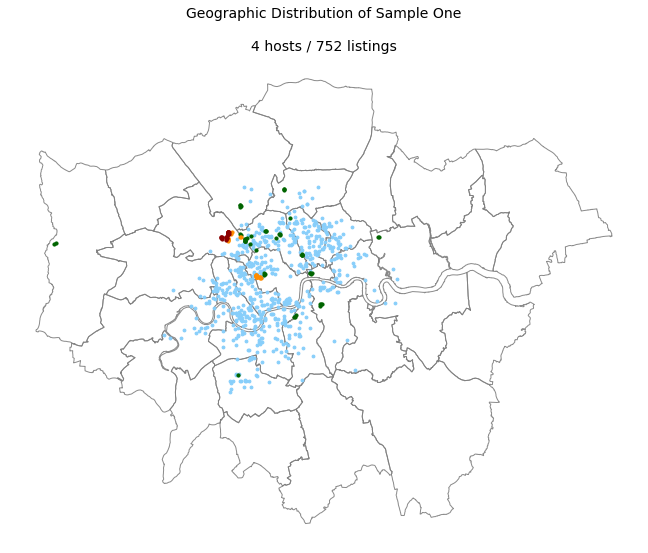

In [82]:
plt.figure(figsize = [12, 8])

ax = lon_nbs.plot(figsize=(12,9), edgecolor='gray', facecolor='none', linewidth=1, alpha=0.9, scheme='Fisher_Jenks')

# Host 1 - 646
ax1 = sus1.plot(markersize=8, color = 'lightskyblue', scheme='Fisher_Jenks', ax=ax)
# Host 2 - 51
ax2 = sus2.plot(markersize=10, color = 'darkgreen', scheme='Fisher_Jenks', ax=ax)
# Host 3 - 31
ax3 = sus3.plot(markersize=10, color = 'darkorange', scheme='Fisher_Jenks', ax=ax)
# Host 4 - 25
ax4 = sus4.plot(markersize=10, color = 'darkred', scheme='Fisher_Jenks', ax=ax)

ax.set_title("Geographic Distribution of Sample One\n\n4 hosts / 752 listings", fontsize=14)
plt.axis('off');

path = os.path.join('','image')
fn = 'fig6'

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
plt.savefig(os.path.join(path,fn), index=False)
print("Done.")

Done.


/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "index" which is no longer supported as of 3.3 and will become an error two minor releases later


<Figure size 864x576 with 0 Axes>

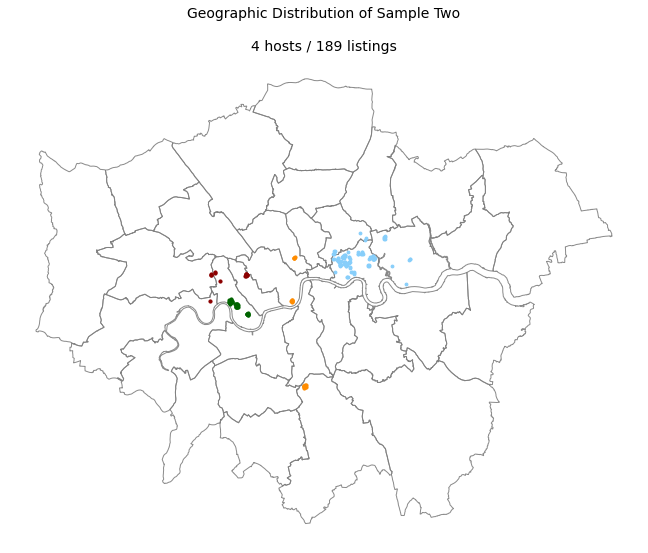

In [83]:
plt.figure(figsize = [12, 8])

ax = lon_nbs.plot(figsize=(12,9), edgecolor='gray', facecolor='none', linewidth=1, alpha=0.9, scheme='Fisher_Jenks')

# Host 5 - 112
ax = sus5.plot(markersize=8, color = 'lightskyblue', scheme='Fisher_Jenks', ax=ax)
# Host 6 - 39
ax = sus6.plot(markersize=10, color = 'darkgreen', scheme='Fisher_Jenks', ax=ax)
# Host 7 - 23
ax = sus7.plot(markersize=10, color = 'darkorange', scheme='Fisher_Jenks', ax=ax)
# Host 8 - 15
ax = sus8.plot(markersize=10, color = 'darkred', scheme='Fisher_Jenks', ax=ax)

ax.set_title("Geographic Distribution of Sample Two\n\n4 hosts / 189 listings", fontsize=14)
plt.axis('off');

path = os.path.join('','image')
fn = 'fig7'

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
plt.savefig(os.path.join(path,fn), index=False)
print("Done.")

#### Coding Credits

1. [Yıldırım, S. (2021b). Data Cleaning and EDA on Airbnb Dataset with Python Pandas and Seaborn. Medium. Available at: https://towardsdatascience.com/data-cleaning-and-eda-on-airbnb-dataset-with-python-pandas-and-seaborn-7c276116b650 (Accessed: 25 January 2022).](https://towardsdatascience.com/data-cleaning-and-eda-on-airbnb-dataset-with-python-pandas-and-seaborn-7c276116b650)

2. [Yıldırım, S. (2021a). Airbnb Data Analysis With Pandas and Seaborn. Medium. Available at: https://betterprogramming.pub/airbnb-data-analysis-with-pandas-and-seaborn-11ceebba1eab (Accessed: 25 January 2022).](https://betterprogramming.pub/airbnb-data-analysis-with-pandas-and-seaborn-11ceebba1eab)

3. [Mendes, B. (2021). AirBnB_Data_Analysis_Toronto. Available at: https://github.com/brunacmendes/Airbnb_Data_Analysis_Toronto/blob/7970932ccaa473cf2fc8a9b6b0a698e733ac5b47/Airbnb_Listings_Data_Analysis_Toronto.ipynb (Accessed: 25 January 2022).](https://github.com/brunacmendes/Airbnb_Data_Analysis_Toronto/blob/main/Airbnb_Listings_Data_Analysis_Toronto.ipynb)

4. [‘End-to-End Predictive Analysis on AirBnB Listings Data’. (2021). Analytics Vidhya, 5 October. Available at: https://www.analyticsvidhya.com/blog/2021/10/end-to-end-predictive-analysis-on-airbnb-listings-data/ (Accessed: 25 January 2022).](https://www.analyticsvidhya.com/blog/2021/10/end-to-end-predictive-analysis-on-airbnb-listings-data/)

5. [Python/Project. AirBnB Part B (Python- Interactive Map, Natural Language Processing) .ipynb at master · Lukastuong123/Python. (no date). GitHub. Available at: https://github.com/Lukastuong123/Python (Accessed: 25 January 2022).](https://github.com/Lukastuong123/Python/blob/master/Project-%20Airbnb%20(Python-%20Interactive%20Map%2C%20Natural%20Language%20Processing%2C%20Comparative%20Study%2C%20Regression)/Project.%20AirBnB%20Part%20B%20(Python-%20Interactive%20Map%2C%20Natural%20Language%20Processing)%20.ipynb)

6. [Tukel, E. (2022). Spatial analysis of Istanbul Airbnb dataset using GeoPandas. Medium. Available at: https://towardsdev.com/spatial-analysis-of-istanbul-airbnb-dataset-using-geopandas-bc2403f8e2d8 (Accessed: 25 January 2022).](https://towardsdev.com/spatial-analysis-of-istanbul-airbnb-dataset-using-geopandas-bc2403f8e2d8)

7. [Week 5: Spatial Data Manipulation and Visualization I — Introduction to Geoprocessing. (no date). Available at: https://spatial-networks-lab.pages.gitlab.kuleuven.be/igp-course-website-2021/week5.html (Accessed: 25 January 2022).](https://spatial-networks-lab.pages.gitlab.kuleuven.be/igp-course-website-2021/week5.html)

8. [Nathan, P. (2020). Visualizing Geospatial Data in Python. Medium. Available at: https://towardsdatascience.com/visualizing-geospatial-data-in-python-e070374fe621 (Accessed: 25 January 2022).](https://towardsdatascience.com/visualizing-geospatial-data-in-python-e070374fe621)

9. [Kumara, H. (2020). ‘How to drop rows based on column values using Pandas Dataframe’. Medium, 28 May. Available at: https://medium.com/@harsz89/how-to-drop-rows-based-on-column-values-using-pandas-dataframe-38cf50e4c95a (Accessed: 25 January 2022).](https://medium.com/@harsz89/how-to-drop-rows-based-on-column-values-using-pandas-dataframe-38cf50e4c95a)

10. [GeoPandas 0.10.2+0.g04d377f.dirty — GeoPandas 0.10.2+0.g04d377f.dirty documentation. (no date). Available at: https://geopandas.org/en/stable/index.html (Accessed: 25 January 2022).](https://geopandas.org/en/stable/index.html)

11. [Matplotlib documentation — Matplotlib 3.5.1 documentation. (no date). Available at: https://matplotlib.org/stable/index.html (Accessed: 25 January 2022).](https://matplotlib.org/stable/index.html)

12. [8 Python Pandas Value_counts() tricks that make your work more efficient. (2020). Re-thought. Available at: https://re-thought.com/pandas-value_counts/ (Accessed: 25 January 2022).](https://re-thought.com/pandas-value_counts/)

13. [Kumar, B. (2021). ‘Matplotlib Pie Chart Tutorial - Python Guides’, 26 December. Available at: https://pythonguides.com/matplotlib-pie-chart/ (Accessed: 25 January 2022).](https://pythonguides.com/matplotlib-pie-chart/)

---

## Part 2 - Executive Briefing

---

### 1 Executive Summary

As of 2021, online accommodation marketplace Airbnb had 5.6 million listings worldwide (Airbnb News 2021) enabling ordinary 
people to share ‘their homes a few nights a month to earn extra income’ (Ngabo 2018). However, the business model has given 
rise to a shadow industry characterized by the phenomenon of ghost hotels - short term rental (STRs) that are not occupied by 
the owner and operate are managed by a company (Chevalier 2019).

This shadow industry is negatively impacting the housing market when, in many cities globally, housing availability and 
affordability are in crisis (Shabrina et al 2021). This report provides an analysis of Airbnb activity in London based on data 
sourced from the Inside Airbnb website for the month of August 2019 – the last summer month prior to the COVID-19 pandemic.

Through exploratory data analysis we set out to answer three main questions about Airbnb in London:

1.	How many listings are not a primary residence of the host?
2.	To what extent are listings professionally managed?
3.	What is the geographic concentration of such listings?

#### Key Findings

- While only 18% of hosts have multiple listings, they represent 45.3% of all listings and an estimated 49% of all profits
- 115 hosts have 25+ listings each and account for 5952 listings alone 
- 11 boroughs have 1000+ listings by hosts with multiple listings
- Most multi-listing hosts seem to be well-established professional operations
- High concentrations of listings suggest not only ghost hotels, but ghost neighbourhoods

#### Recommendations to the Mayor

While implementing the ‘90-day rule’ in 2017, research suggests that further Airbnb regulations benefit cities with a higher 
tourism like London (Grimmer, et. al. 2019). Accordingly, the following recommendations aim to provide a path forward:

1.	Establish definitions for STRs and principal residences;
2.	Use the definitions to draft legislation requiring STRs to be registered and/or licensed with the city; and
3.	Use registration/licenses to enforce the following requirements:
    -	that STRs to include the registration/license number in their listing;
    -	that STRs only be permitted in an owner's principal residence; and
    -	that only STRs with registration/license numbers be permitted to be professionally managed.

---

### 2 Background

#### Airbnb

Airbnb is a global, online platform operating as a marketplace where users can ‘list their space and book unique accommodations 
anywhere in the world’ (Airbnb 2021). While Airbnb’s messaging suggests it facilitates homeowners to make extra income by 
offering their spare rooms or their entire home for when they are away (Airbnb 2021), there is also substantial evidence the 
platform both directly (Cox & Slee 2016) and indirectly (Bivens 2019) limits transparency needed for proper enforcement. On the 
surface, Airbnb’s promise as part of the sharing economy seems genuine, however, data has demonstrated the platform has 
transitioned to ‘commercial-style Airbnb’s’ (Nieuwland & van Melik 2020) where most listings are for ‘entire homes, many of 
which are rented all year round - disrupting housing and communities’ (Inside Airbnb 2022). 

#### Inside Airbnb

Inside Airbnb is an activist project which sources, cleans, analyzes and aggregates publicly available data from the Airbnb 
website. The service, which represents a growing movement pushing STR platforms to pay their fair share (Wachsmuth & Weisler 2018), 
scrapes data from the Airbnb website to contextualize impacts on housing markets and support ongoing debate (Inside Airbnb 2022). 
While owner information is not public, according to Fairbnb (2019) ‘Airbnb has access to data that makes it clear to them who those 
ghost hotel operators are’ and therefore could implement regulation to stop them.

#### 'Ghost Hotels'

Ghost hotels is a term used to describe Airbnb listings that are not part of the sharing economy, but rather ‘homes and units, 
often purchased in bulk by corporations and taken permanently off the rental market’ (ONeil 2019, Cocola-Gant and Gago 2019). 
By virtue of using an online platform and self check-in, they effectively operate as ‘small-scale lodging companies’ or ‘mini hotels’
(Bivens 2019) and are in complete opposition to the ‘connection [and] deeply personal experience’ (Chesky et al. 2021) that is, 
according to Airbnb, at its core. While some regulation has been put in place in London, such as automatic booking limits to 90 
nights per year (Airbnb 2022), ghost hotels have found workarounds to continue to operate and turn entire buildings into hotels (Temperton 2020).

---

### 3 Analysis

At all points of this analysis, fields that could potentially contain personal or identifiable information have been removed. This 
analysis has been completed based on the following methodology:

- **STEP 1:** Find ‘hotel rooms’ – filter listings based on minimum stay offered and by hosts with multiple listings
- **STEP 2:** Find ‘hotel staff’ – analyze similarity and professionalism within the name and descriptions fields of listings
- **STEP 3:** Find ‘hotels’ – explore the geographical concentration of listings by hosts with multiple listings

#### QUESTION ONE - How many listings are not the primary residence of the host?

Data from August 2019 revealed 84412 total listings. During data cleaning, only listings with minimum stays less than 28 days were kept. 
This left 76692 listings (98.3%), but only 51121 total hosts - a difference of 25571 listings. Next, all hosts with single-listings were 
removed, leaving only hosts with multiple listings for analysis – 34757 listings. 

Figure 1 provides a comparison of findings between single-hosts and multi-hosts. The findings of this report confirm that, like findings 
of prior studies conducted in other cities (Bivens 2019, Dogru, et. al. 2020), London’s Airbnb supply relies heavily on hosts of multiple 
units for its listings and revenue. It should be noted that People Accommodated and Profit are meant to be per night estimates assuming 
full bookings.

##### Figure 1 – Comparison of Single-host Listings to Multi-host Listings
![fig1](image/fig1.png)

#### QUESTION TWO - To what extent are listings professionally managed?

Two samples of four hosts each were taken to analyze their name and description fields. The first sample was from all multi-host listings. 
The second sample was from a sub-set of multi-host listings consisting only of private room listings. The hosts have been anonymized in this report.

##### Sample One

The four hosts sampled offered 753 listings, ranging from 646 to 25 listings each. Another sample of eight random listings was taken 
from each of the four hosts. The name and description fields used by three of the hosts were nearly identical and all three also 
classified their listings by a code – like a hotel suite. For example, one host had three different listings labelled GR R1, GR R4, 
and GR R7. While the host with 646 listings did not classify or use identical descriptions, the name of every listing included the name 
of a company. After further research, this company was determined to be a property management company that manages listings on behalf of 
private owners. It is more likely that this host is an agent than a homeowner and exemplifies how property management companies have come 
to represent the ‘professional business of Airbnb rentals’ (Leshinsky & Schatz 2018) while ensuring ‘absentee property owners’ (Bivens 2019) 
remain anonymous from enforcement.

##### Sample Two

The four hosts of sample two offered 189 listings, ranging from 112 to 15 listings each. Another sample of eight random listings was taken 
from each of these four hosts. Once again, the name and description fields of all host’s listings were either nearly identical or very similar. 
Similarly, three of the four hosts classified their listings by code. 

#### QUESTION THREE - What is the concentration of the listings identified above?

Figures 2 and 3 show the distribution of multi-host listings by borough. Multi-listings are spread throughout London but are highly 
concentrated in the inner-boroughs – especially Westminster, Tower Hamlets, Camden, and Kensington and Chelsea. This remains consistent 
with a 2016 study which found the highest concentration of Airbnb listings in the same four boroughs (Ferreri & Sanyal 2018).

##### Figure 2 - Density of Multi-host Listings by Borough
![fig4](image/fig4.png)

##### Figure 3 – Boroughs Ranked by Number of Multi-host Listings
![fig5](image/fig5.png)

Figure 4 shows the geographic distribution of sampled professionally managed listings. The green and blue hosts are geographically 
dispersed predominantly within the inner boroughs. The red and yellow hosts however are very concentrated. For example, the red host 
has 25 listings but seemingly only 3 overlapping points.

##### Figure 4 - Concentration of Sample One - Multi-host Listings
![fig6](image/fig6.png)

Figure 5 shows the geographic concentration of sampled private room listings. There is clearly a much higher concentration among this 
sample than the previous one. For instance, the red, yellow, and green hosts have 15, 23, and 39 listings each, but only appear to have 
4, 3, and 3 points each, respectively. There is a high probability that ghost hotels are present within this sample. The blue host seems 
more dispersed but is still highly centred on a single neighbourhood - Tower Hamlets. Collectively, all four hosts can be seen as an 
illustration of the potential for listings to dominate ‘entire apartment blocks or even neighbourhoods’ (Nieuwland & van Melik 2020). 

##### Figure 5 - Concentration of Sample Two - Private Room Listings
![fig7](image/fig7.png)

---

### 4 Conclusion

It is clear from this analysis that hosts with multiple listings dominate the STR market in London. The ’90-day-rule” has not prevented 
the displacement of rental units in favour of STR, income generating properties. Further rules need to be put in place starting by 
establishing clear definitions for STRs and principal residences. Once these definitions are established, they need to be linked through 
accompanying legislation that requires STRs to be registered/licensed by their owner and for the registration/license number to be displayed
in all listings of the STR.

Once STRs are required to be registered/licensed, enforcement becomes much easier. London authorities and administrative staff will be 
able to determine whether an STR is the owner’s private residence. Further, requiring STRs to be registered and/or licensed with the 
city would also allow enforcement to begin that prohibits professional management companies from representing or providing services to 
STRs that are not registered/licensed. By illuminating the practice, the negative impacts of the STR shadow industry can be monitored and addressed.

---

### 5 Bibliography

1. [Airbnb (2022) ‘About us’ (WWW) Airbnb Newsroom (https://news.airbnb.com/about-us/; 20 January 2022).](https://news.airbnb.com/about-us/)

2. [Airbnb (2022) ‘Responsible hosting in the United Kingdom’ (WWW) Airbnb Help Centre (https://www.airbnb.ca/help/article/1379/responsible-hosting-in-the-united-kingdom; 20 January 2022).](https://www.airbnb.ca/help/article/1379/responsible-hosting-in-the-united-kingdom)

3. [Airbnb (2022) ‘What is Airbnb and how does it work?’ (WWW) Airbnb Help Centre (https://www.airbnb.ca/help/article/2503/what-is-airbnb-and-how-does-it-work; 20 January 2022).](https://www.airbnb.ca/help/article/2503/what-is-airbnb-and-how-does-it-work)

4. [Bivens, J. (2019). ‘The economic costs and benefits of Airbnb: No reason for local policymakers to let Airbnb bypass tax or regulatory obligations’. Economic Policy Institute. Available at: https://www.epi.org/publication/the-economic-costs-and-benefits-of-airbnb-no-reason-for-local-policymakers-to-let-airbnb-bypass-tax-or-regulatory-obligations/ (Accessed: 26 January 2022).](https://www.epi.org/publication/the-economic-costs-and-benefits-of-airbnb-no-reason-for-local-policymakers-to-let-airbnb-bypass-tax-or-regulatory-obligations/)

5. [Chesky, B., Blecharcyzk, N. and Gebbia, J. (2021) ‘What Makes Airbnb, Airbnb’, (WWW) Airbnb Newsroom (https://news.airbnb.com/what-makes-airbnb-airbnb/; 20 January 2022).](https://news.airbnb.com/what-makes-airbnb-airbnb/)

6. [Chevalier, J. (2019) ‘These guys are predators’: Condo owner says home turned into Airbnb ‘ghost hotel’ (WWW) CBC News (https://www.cbc.ca/news/canada/ottawa/condo-owner-violated-airbnb-ghost-hotel-1.5122219; 20 January 2022).](https://www.cbc.ca/news/canada/ottawa/condo-owner-violated-airbnb-ghost-hotel-1.5122219)

7. [Cocola-Gant, A. and Gago, A. (2021) ‘Airbnb, buy-to-let investment and tourism-driven displacement: A case study in Lisbon’, Environment and Planning A: Economy and Space, 53(7), pp. 1671–1688.](https://doi.org/10.1177/0308518X19869012)

8. [Cox, M. and Slee, T. (2016). ‘How Airbnb’s data hid the facts in New York City’, p. 16.](http://insideairbnb.com/reports/how-airbnbs-data-hid-the-facts-in-new-york-city.pdf)

9. [Dogru, T., Mody, M., Suess, C., Line, N. and Bonn, M. (2020). ‘Airbnb 2.0: Is it a sharing economy platform or a lodging corporation?’ Tourism Management, 78, p. 104049. doi: 10.1016/j.tourman.2019.104049.](https://doi.org/10.1016/j.tourman.2019.104049)
        
10. [Ferreri, M. and Sanyal, R. (2018). ‘Platform economies and urban planning: Airbnb and regulated deregulation in London’. Urban Studies. SAGE Publications Ltd, 55 (15), pp. 3353–3368. doi: 10.1177/0042098017751982.](https://doi.org/10.1177/0042098017751982)
        
11. [Grimmer, L., Vorobjovas-Pinta, O. and Massey, M. (2019). ‘Regulating, then deregulating Airbnb: The unique case of Tasmania (Australia)’. Annals of Tourism Research, 75, pp. 304–307. doi: 10.1016/j.annals.2019.01.012.](https://doi.org/10.1016/j.annals.2019.01.012)
        
12. [Inside Airbnb (2022) ‘Inside Airbnb. Adding data to the debate’ (WWW) Inside Airbnb (http://insideairbnb.com; 20 January 2022).](http://insideairbnb.com/)

13. [Leshinsky, R. and Schatz, L. (2018). ‘“I Don’t Think My Landlord Will Find Out:” Airbnb and the Challenges of Enforcement’. Urban Policy and Research. Routledge, 36 (4), pp. 417–428. doi: 10.1080/08111146.2018.1429260.](https://doi-org.libproxy.ucl.ac.uk/10.1080/08111146.2018.1429260)

14. [Ngabo, G. (2018) ‘Home-sharing watchdog warns of “ghost hotels”’ (WWW) The Toronto Star (https://www.thestar.com/news/gta/2018/12/17/home-sharing-watchdog-warns-of-ghost-hotels.html; 20 January 2022).](https://www.thestar.com/news/gta/2018/12/17/home-sharing-watchdog-warns-of-ghost-hotels.html)

15. [Nieuwland, S. and van Melik, R. (2020). ‘Regulating Airbnb: how cities deal with perceived negative externalities of short-term rentals’. Current Issues in Tourism. Routledge, 23 (7), pp. 811–825. doi: 10.1080/13683500.2018.1504899.](https://doi-org.libproxy.ucl.ac.uk/10.1080/13683500.2018.1504899)

16. [O’Neil, L. (2019) ‘Toronto officially asks Airbnb to take down ghost hotels’ (WWW) BlogTO (https://www.blogto.com/real-estate-toronto/2019/02/airbnb-toronto-ghost-hotels-city-council-vote/; 20 January 2022).](https://www.blogto.com/real-estate-toronto/2019/02/airbnb-toronto-ghost-hotels-city-council-vote/)

17. [Shabrina, Z., Arcaute, E. and Batty, M. (2022a) ‘Airbnb and its potential impact on the London housing market’, Urban Studies, 59(1), pp. 197–221.](https://doi.org/10.1177/0042098020970865)

18. [Temperton, J. (2020) ‘I stumbled across a huge Airbnb scam that’s taking over London’ (WWW) Wired UK (https://www.wired.co.uk/article/airbnb-scam-london; 20 January2022).](https://www.wired.co.uk/article/airbnb-scam-london)

19. [Wachsmuth, D. and Weisler, A. (2018). ‘Airbnb and the rent gap: Gentrification through the sharing economy’. Environment and Planning A: Economy and Space. SAGE Publications Ltd, 50 (6), pp. 1147–1170. doi: 10.1177/0308518X18778038.](https://doi.org/10.1177/0308518X18778038)